In [2]:
import pyModeS as pyms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

pd.set_option("display.float_format", lambda x: "%.8f" % x)
%load_ext lab_black
%load_ext nb_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


# Let's load some sample data.

In [3]:
data = pd.read_csv("data/samples.csv", names=["timestamp", "message"])
print(data)

               timestamp                       message
0    1568017731.14865947  8D4C01E45805B649D8EDDF517B23
1    1568017731.36364746                0246009B4584F0
2    1568017731.46985078                5D4C01E4BC9DD0
3    1568017731.96225739                0241009C9B7913
4    1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3
...                  ...                           ...
7748 1568019594.57212925                5D4C01E4BC9DF0
7749 1568019596.27935791                5D4C01E4BC9DCC
7750 1568019596.29236126                02E1979FF80121
7751 1568019596.42234182                02E6179F203CC2
7752 1568019598.92450905  8D4C01E458BDF15F63F10BB59763

[7753 rows x 2 columns]


## Which aircraft broadcasted these messages?
We need to indentify the transponder address.

In [4]:
data["icao"] = data.message.apply(pyms.icao)
print(data)

               timestamp                       message    icao
0    1568017731.14865947  8D4C01E45805B649D8EDDF517B23  4C01E4
1    1568017731.36364746                0246009B4584F0  4C01E4
2    1568017731.46985078                5D4C01E4BC9DD0  4C01E4
3    1568017731.96225739                0241009C9B7913  4C01E4
4    1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3  4C01E4
...                  ...                           ...     ...
7748 1568019594.57212925                5D4C01E4BC9DF0  4C01E4
7749 1568019596.27935791                5D4C01E4BC9DCC  4C01E4
7750 1568019596.29236126                02E1979FF80121  4C01E4
7751 1568019596.42234182                02E6179F203CC2  4C01E4
7752 1568019598.92450905  8D4C01E458BDF15F63F10BB59763  4C01E4

[7753 rows x 3 columns]


## What kind of messages are we looking at?

In [5]:
# Compute the Downlink Format
data["DF"] = data.message.apply(pyms.df)
print(data)

               timestamp                       message    icao  DF
0    1568017731.14865947  8D4C01E45805B649D8EDDF517B23  4C01E4  17
1    1568017731.36364746                0246009B4584F0  4C01E4   0
2    1568017731.46985078                5D4C01E4BC9DD0  4C01E4  11
3    1568017731.96225739                0241009C9B7913  4C01E4   0
4    1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3  4C01E4  17
...                  ...                           ...     ...  ..
7748 1568019594.57212925                5D4C01E4BC9DF0  4C01E4  11
7749 1568019596.27935791                5D4C01E4BC9DCC  4C01E4  11
7750 1568019596.29236126                02E1979FF80121  4C01E4   0
7751 1568019596.42234182                02E6179F203CC2  4C01E4   0
7752 1568019598.92450905  8D4C01E458BDF15F63F10BB59763  4C01E4  17

[7753 rows x 4 columns]


Recall the downlink format
```
DF 0: Short air-air surveillance
DF 4: Surveillance, altitude reply
DF 5: Surveillance, identity reply
DF 11: All call reply
DF 16: Long air-air surveillance
DF 17: Extended squitter
DF 18: Extended squitter/non transponder
DF 19: Military extended squitter
DF 20: Comm-B, altitude reply
DF 21: Comm-B, identity reply
DF 24: Comm-D (Extended Length Message)
```

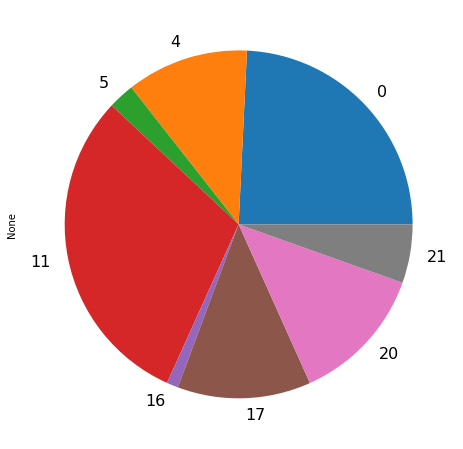

In [6]:
# Analyze the distributions of downlink format among messages
data.groupby("DF").size().plot(kind="pie", figsize=(8, 8), fontsize=16)

---
# Work with different types of ADS-B messages

## Filter out all the ADS-B messages

In [7]:
adsb = data[data.DF == 17].copy()
print(adsb)

               timestamp                       message    icao  DF
0    1568017731.14865947  8D4C01E45805B649D8EDDF517B23  4C01E4  17
4    1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3  4C01E4  17
6    1568017732.67249036  8D4C01E499440793008802D2D79C  4C01E4  17
11   1568017733.05163741  8D4C01E45805E6499CEDDEE1391C  4C01E4  17
15   1568017733.17931867  8D4C01E499440793008802D2D79C  4C01E4  17
...                  ...                           ...     ...  ..
7688 1568019528.83428454  8D4C01E4994143AA48080394EBAD  4C01E4  17
7705 1568019544.14125061  8D4C01E4994142AA480403DFBB63  4C01E4  17
7715 1568019547.72472954  8D4C01E4994142AA48080397E163  4C01E4  17
7745 1568019591.09323001  8D4C01E458BDF4D30BE304169D14  4C01E4  17
7752 1568019598.92450905  8D4C01E458BDF15F63F10BB59763  4C01E4  17

[962 rows x 4 columns]


## What do these ADS-B message tell us?
We need to find out the **Type Code** of the messages, recall that:
```
TC=1-4:    Identity message
TC=5-8:    Surface movement message
TC=9-18:   Airborn position message (with barometric altitude)
TC=19:     Airborne velocity message
TC=20-22:  Airborn position message (with GNSS altitude)
```

In [8]:
adsb["TC"] = adsb.message.apply(pyms.adsb.typecode)
print(adsb.head(20))

              timestamp                       message    icao  DF  TC
0   1568017731.14865947  8D4C01E45805B649D8EDDF517B23  4C01E4  17  11
4   1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3  4C01E4  17  11
6   1568017732.67249036  8D4C01E499440793008802D2D79C  4C01E4  17  19
11  1568017733.05163741  8D4C01E45805E6499CEDDEE1391C  4C01E4  17  11
15  1568017733.17931867  8D4C01E499440793008802D2D79C  4C01E4  17  19
18  1568017733.58993077  8D4C01E499440793008C03151595  4C01E4  17  19
20  1568017733.91328669  8D4C01E45805F64984EDDD9D9BF6  4C01E4  17  11
22  1568017734.65430713  8D4C01E499440792E09402742819  4C01E4  17  19
25  1568017734.87910652  8D4C01E4580702DE2AF4A88E9702  4C01E4  17  11
34  1568017735.67697859  8D4C01E499440792E09402742819  4C01E4  17  19
47  1568017736.66998363  8D4C01E499440692E094027722D7  4C01E4  17  19
54  1568017737.58333564  8D4C01E499440692E094027722D7  4C01E4  17  19
71  1568017738.54016900  8D4C01E499440692E0940388D6DE  4C01E4  17  19
73  1568017738.84662

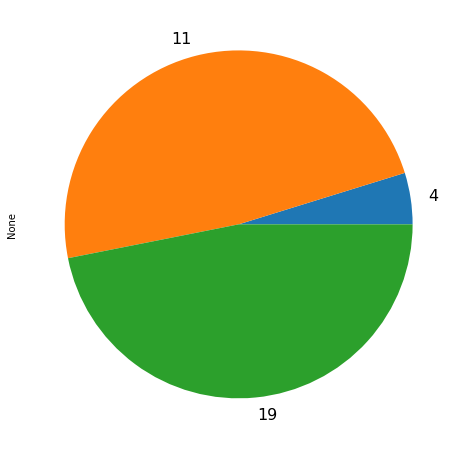

In [9]:
adsb.groupby("TC").size().plot(kind="pie", figsize=(8, 8), fontsize=16)

---
## Aircraft indentity
Let's take a look at the following identity message:
```
              timestamp                       message    icao  DF  TC
104 1568017740.09914660  8D4C01E420053332C1A8207D484C  4C01E4  17   4
```

In [10]:
pyms.adsb.callsign("8D4C01E420053332C1A8207D484C")

'ASL20Z__'

---
## Aircraft velocity (airborne)
Let's take a look at the following airborne velocity message:
```
              timestamp                       message    icao  DF  TC
15  1568017732.67249036  8D4C01E499440793008802D2D79C  4C01E4  17  19
```

In [11]:
pyms.adsb.velocity("8D4C01E499440793008802D2D79C")
# speed (kt), heading (degree), vertical rate (fpm), 'GS'or'TAS'

(151, 182.28, 2112, 'GS')

---
## Aircraft position (airborne)
There two ways to decode aircraft messages:
1. Decode with **two messages** (odd and even position frame)
2. Decode with **one message with a reference position** (once aircraft is lock through 1)

In [12]:
# compute the "odd/even" indicator
positions = adsb[adsb.TC.between(5, 18)].copy()
positions["oe"] = positions.message.apply(pyms.adsb.oe_flag)
print(positions.head(15))

              timestamp                       message    icao  DF  TC  oe
0   1568017731.14865947  8D4C01E45805B649D8EDDF517B23  4C01E4  17  11   1
4   1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3  4C01E4  17  11   0
11  1568017733.05163741  8D4C01E45805E6499CEDDEE1391C  4C01E4  17  11   1
20  1568017733.91328669  8D4C01E45805F64984EDDD9D9BF6  4C01E4  17  11   1
25  1568017734.87910652  8D4C01E4580702DE2AF4A88E9702  4C01E4  17  11   0
73  1568017738.84662271  8D4C01E4580762DDB2F4A608CC43  4C01E4  17  11   0
84  1568017739.66207552  8D4C01E4580782DD9AF4A6FA6B2B  4C01E4  17  11   0
94  1568017740.24300122  8D4C01E458079648C6EDDA6EB43C  4C01E4  17  11   1
104 1568017740.77455497  8D4C01E458079648BAEDD9DA6F49  4C01E4  17  11   1
117 1568017741.70495009  8D4C01E45807B2DD5EF4A4FC2FEB  4C01E4  17  11   0
124 1568017742.67065692  8D4C01E45807D6487EEDD8B0853B  4C01E4  17  11   1
135 1568017743.58346081  8D4C01E45807E64866EDD8529603  4C01E4  17  11   1
152 1568017744.70360470  8D4C01E458090

### Decoding with two messages (globally unambiguous position)
```
              timestamp                       message    icao  DF  TC  oe
9   1568017731.14865947  8D4C01E45805B649D8EDDF517B23  4C01E4  17  11   1
13  1568017732.07376266  8D4C01E45805C2DE80F4AAF961B3  4C01E4  17  11   0
```

In [13]:
pyms.adsb.position(
    "8D4C01E45805C2DE80F4AAF961B3",
    "8D4C01E45805B649D8EDDF517B23",
    1568017732,
    1568017731,
)
# latutude, longitude

(52.30371, 4.77859)

### Decoding with one message (locally unambiguous position)
```
              timestamp                       message    icao  DF  TC  oe
20  1568017733.05163741  8D4C01E45805E6499CEDDEE1391C  4C01E4  17  11   1
```
Considering position (-51.71628, -2.55447) from previous example

In [14]:
pyms.adsb.position_with_ref("8D4C01E45805E6499CEDDEE1391C", 52.30371, 4.77859)
# latutude, longitude

(52.30302, 4.77858)

---
# Decode all positions and velocities

In [15]:
positions = []
velocities = []


lat, lon = (52.30302, 4.77858)
for idx, row in adsb[adsb.TC.between(5, 18)].iterrows():
    lat, lon = pyms.adsb.position_with_ref(row.message, lat_ref=lat, lon_ref=lon)
    alt = pyms.adsb.altitude(row.message)
    positions.append((row.timestamp, lat, lon, alt))

for idx, row in adsb[adsb.TC == 19].iterrows():
    spd, trk, vs, label = pyms.adsb.velocity(row.message)
    velocities.append((row.timestamp, spd, trk, vs))

In [16]:
t1, lat, lon, alt = zip(*positions)
t2, spd, trk, vs = zip(*velocities)

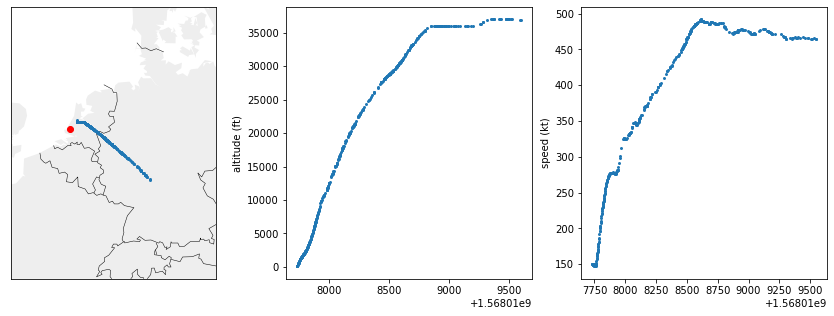

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
m = Basemap(
    llcrnrlon=min(lon) - 4,
    llcrnrlat=min(lat) - 4,
    urcrnrlon=max(lon) + 4,
    urcrnrlat=max(lat) + 4,
    resolution="l",
    projection="merc",
)
m.fillcontinents(color="#eeeeee")
m.drawcountries()
# plot SIL as a fix point
latSIL = 51.989884
lonSIL = 4.375374
m.plot(lonSIL, latSIL, latlon=True, marker="o", c="red", zorder=9)
m.scatter(lon, lat, latlon=True, marker=".", lw=0, zorder=10)

plt.subplot(132)
plt.scatter(t1, alt, marker=".", lw=0)
plt.ylabel("altitude (ft)")

plt.subplot(133)
plt.scatter(t2, spd, marker=".", lw=0)
plt.ylabel("speed (kt)")
plt.show()